In [ ]:
!pip install -r ./requirements.txt

In [1]:
!python3 -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python3 -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

You should consider upgrading via the '/root/miniconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
import re, time, os, shutil, json
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import SimpleITK as sitk  # noqa: N813
import numpy as np
import nibabel as nib
from PIL import Image
from monai.data import create_test_image_3d, list_data_collate, decollate_batch, pad_list_data_collate
import tempfile
import monai
from monai.inferers import sliding_window_inference
from monai.data import ITKReader, PILReader, ImageDataset, DataLoader, Dataset, PersistentDataset, CacheDataset, ArrayDataset
from monai.networks.layers import Norm
from monai.transforms import (
    LoadImage, EnsureChannelFirst, Spacing,
    RandFlip, Resize, EnsureType,
    LoadImaged, EnsureChannelFirstd,
    Resized, EnsureTyped, Compose, ScaleIntensityd, AddChanneld, MapTransform, AsChannelFirstd, EnsureType, Activations, AsDiscrete,
    RandCropByPosNegLabeld, RandRotate90d, LabelToMaskd, RandFlipd, RandRotated, Spacingd, RandAffined
)
#from monai.networks.nets import UNETR
#from torch.utils.tensorboard import SummaryWriter
from monai.transforms.intensity.array import ScaleIntensity
from monai.metrics import DiceMetric
import configdot
import torch
from monai.config import print_config
#from monai.engines import create_multigpu_supervised_trainer

print_config()

MONAI version: 0.9.0
Numpy version: 1.19.0
Pytorch version: 1.8.1+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: af0e0e9f757558d144b655c63afcea3a4e0a06f5
MONAI __file__: /root/miniconda3/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.0
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.1.0
Tensorboard version: 2.9.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.64.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.4.2
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-th

In [3]:
!mkdir -p ./MONAI_TMP

In [4]:
config = configdot.parse_config('configs/config.ini')

In [5]:
os.environ['MONAI_DATA_DIRECTORY'] = "./MONAI_TMP"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

./MONAI_TMP


In [6]:
BASE_DIR = '/workspace/RawData/Features'
OUTPUT_DIR = '/workspace/RawData/Features/BIDS'
TMP_DIR = '/workspace/Features/tmp'

In [7]:
!ls /workspace/RawData/Features/prep_wf | wc

    206     206    1613


In [8]:
def assign_feature_maps(sub, feature):
    global BASE_DIR
    global OUTPUT_DIR
    global TMP_DIR
    if feature == 'image':
        feature_map = os.path.join(BASE_DIR, f'prep_wf', f'sub-{sub}', f'sub-{sub}_t1_brain-final.nii.gz')
    elif feature == 't2':
        feature_map = os.path.join(BASE_DIR, f'prep_wf', f'sub-{sub}', f'sub-{sub}_t2_brain-final.nii.gz')
    elif feature == 'flair':
        feature_map = os.path.join(BASE_DIR, f'prep_wf', f'sub-{sub}', f'sub-{sub}_fl_brain-final.nii.gz')
    elif feature == 'blurring-t1':
        feature_map = os.path.join(BASE_DIR, f'prep_wf', f'sub-{sub}', f'Blurring_T1.nii.gz')
    elif feature == 'blurring-Flair':
        feature_map = os.path.join(BASE_DIR, f'prep_wf', f'sub-{sub}', f'Blurring_Flair.nii.gz')
    elif feature == 'cr-t2':
        feature_map = os.path.join(BASE_DIR, f'prep_wf', f'sub-{sub}', f'CR_T2.nii')
    elif feature == 'cr-Flair':
        feature_map = os.path.join(BASE_DIR, f'prep_wf', f'sub-{sub}', f'CR_Flair.nii')
    elif feature == 'thickness':
        feature_map = os.path.join(BASE_DIR, f'prep_wf', f'sub-{sub}', f'thickness_mni.nii')
    elif feature == 'curv':
        feature_map = os.path.join(BASE_DIR, f'prep_wf', f'sub-{sub}', f'curv_mni.nii')
    elif feature == 'sulc':
        feature_map = os.path.join(BASE_DIR, f'prep_wf', f'sub-{sub}', f'sulc_mni.nii')
    elif feature == 'variance':
        feature_map = os.path.join(BASE_DIR, f'preprocessed_data', 'var', f'sub-{sub}_var.nii.gz')
    elif feature == 'mask':
        feature_map = os.path.join(BASE_DIR, f'prep_wf', f'sub-{sub}', f'sub-{sub}_t1_brain-final_mask.nii.gz')
    return feature_map

### images_list also Checks that features and labels available and returns number of available subjects

In [9]:
from sklearn.model_selection import train_test_split

images_list = []
subject_list = []
# Choose subjects indexes to include
matches = config.dataset.subj_ind_to_exclude
feat_params = config.dataset.features
# {'image': ['/workspace/Features/preprocessed_data/new_pipeline/sub-8/sub-8_acq-T1Mprage_space-MNI152NLint2_seq-T1w_brain.nii.gz',
#   '/workspace/Features/preprocessed_data/thickness/norm-8.nii.gz',
#   '/workspace/Features/preprocessed_data/curv/norm-8.nii.gz',
#           ]
# }

for i in os.listdir(OUTPUT_DIR):
    sub_ind = re.findall('-(.[a-zA-Z0-9]*|[0-9])', str(i))
    if sub_ind and not any(x in sub_ind[0] for x in matches): # subjects with 'n', 'G', 'NS', 'C' won't be included
        subject_list.append(sub_ind[0])
        
random_seed = 666    
train_list, val_list = train_test_split(subject_list, shuffle=False, train_size=0.80, random_state=random_seed)

train_subs_indcs = []
train_files = []

for sub in train_list:
    images_per_sub = dict()
    images_per_sub['image'] = []
    for feat in feat_params:
        map_path = assign_feature_maps(sub, feat)
        if os.path.isfile(map_path):
            images_per_sub['image'].append(map_path)
        else:
            continue
    if len(images_per_sub['image']) == len(feat_params):
        seg_path = os.path.join(BASE_DIR, 'preprocessed_data/label_bernaskoni', f'{sub}.nii.gz')
        if os.path.isfile(seg_path):
            images_per_sub['seg'] = seg_path
        else:
            continue
        train_subs_indcs.append(sub)
        train_files.append(images_per_sub)

val_subs_indcs = []
val_files = []

for sub in val_list:
    images_per_sub = dict()
    images_per_sub['image'] = []
    for feat in feat_params:
        map_path = assign_feature_maps(sub, feat)
        if os.path.isfile(map_path):
            images_per_sub['image'].append(map_path)
        else:
            print(f'No feature {feat} for sub {sub}')
            continue
    if len(images_per_sub['image']) == len(feat_params):
        seg_path = os.path.join(BASE_DIR, 'preprocessed_data/label_bernaskoni', f'{sub}.nii.gz')
        if os.path.isfile(seg_path):
            images_per_sub['seg'] = seg_path
        else:
            print(f'No {seg_path} for sub {sub}')
            continue
        val_subs_indcs.append(sub)
        val_files.append(images_per_sub)

print(f"Train set length: {len(train_files)}\nTest set length: {len(val_files)}")

No feature thickness for sub 97
No feature image for sub 12
No feature flair for sub 12
No feature thickness for sub 12
No feature blurring-t1 for sub 12
Train set length: 53
Test set length: 13


In [11]:
images_list = []
#feat_params = ['image', 't2', 'thickness', 'blurring-t1']
feat_params = config.dataset.features
#feat_params = ['t1_raw']
subject_list = []
# {'image': ['/workspace/Features/preprocessed_data/new_pipeline/sub-8/sub-8_acq-T1Mprage_space-MNI152NLint2_seq-T1w_brain.nii.gz',
#   '/workspace/Features/preprocessed_data/thickness/norm-8.nii.gz',
#   '/workspace/Features/preprocessed_data/curv/norm-8.nii.gz',
for i in os.listdir(OUTPUT_DIR):
    sub_ind = re.findall('-(.[a-zA-Z0-9]*|[0-9])', str(i))
    if sub_ind:
        subject_list.append(sub_ind[0])

for sub in subject_list:
    images_per_sub = dict()
    images_per_sub['image'] = []
    for feat in feat_params:
        map_path = assign_feature_maps(sub, feat)
        if os.path.isfile(map_path):
            images_per_sub['image'].append(map_path)
        else:
            continue
    if len(images_per_sub['image']) == len(feat_params):
        #print(f'For subject {sub} all feature files are set')
        seg_path = os.path.join(BASE_DIR, 'preprocessed_data/label_bernaskoni', f'{sub}.nii.gz')
        if os.path.isfile(seg_path):
            images_per_sub['seg'] = seg_path
        else:
            continue
        images_list.append(images_per_sub)
        
from sklearn.model_selection import train_test_split
random_seed = 666
train_files, val_files = train_test_split(images_list, shuffle=False, train_size=0.80, random_state=random_seed)
print(f"Train set length: {len(train_files)}\nTest set length: {len(val_files)}")

Train set length: 147
Test set length: 37


In [11]:
"""
images_list = []
subject_list = ['1', '3', '4', '6', '8']

# {'image': '/workspace/Features/preprocessed_data/new_pipeline/sub-8/sub-8_acq-T1Mprage_space-MNI152NLint2_seq-T1w_brain.nii.gz',
#  'thickness': '/workspace/Features/preprocessed_data/thickness/norm-8.nii.gz',
#  'curv': '/workspace/Features/preprocessed_data/curv/norm-8.nii.gz',
#  'sulc': '/workspace/Features/preprocessed_data/sulc/norm-8.nii.gz',

for sub in subject_list:
    image_per_sub = dict()
    image_per_sub['image'] = {}
    for feat in feat_params:
        map_path = assign_feature_maps(sub, feat)
        if os.path.isfile(map_path):
            image_per_sub[feat] = map_path
    image_per_sub['seg'] = os.path.join(BASE_DIR, 'label', f'{sub}.nii.gz')
    if os.path.isfile(map_path):
        images_list.append(image_per_sub)
"""

"\nimages_list = []\nsubject_list = ['1', '3', '4', '6', '8']\n\n# {'image': '/workspace/Features/preprocessed_data/new_pipeline/sub-8/sub-8_acq-T1Mprage_space-MNI152NLint2_seq-T1w_brain.nii.gz',\n#  'thickness': '/workspace/Features/preprocessed_data/thickness/norm-8.nii.gz',\n#  'curv': '/workspace/Features/preprocessed_data/curv/norm-8.nii.gz',\n#  'sulc': '/workspace/Features/preprocessed_data/sulc/norm-8.nii.gz',\n\nfor sub in subject_list:\n    image_per_sub = dict()\n    image_per_sub['image'] = {}\n    for feat in feat_params:\n        map_path = assign_feature_maps(sub, feat)\n        if os.path.isfile(map_path):\n            image_per_sub[feat] = map_path\n    image_per_sub['seg'] = os.path.join(BASE_DIR, 'label', f'{sub}.nii.gz')\n    if os.path.isfile(map_path):\n        images_list.append(image_per_sub)\n"

In [10]:
#### JUST IMAGE AND BRAIN MASK

"""
subject_list = []
images_list = []

for i in os.listdir(BASE_DIR + '/fmriprep'):
    if os.path.isdir(os.path.join(BASE_DIR + '/fmriprep', i)):
        sub_ind = re.findall('^sub-(?!C)(.[a-zA-Z0-9]*|[0-9])', str(i))
        if sub_ind:  
            subject_list.append(sub_ind[0])
            t1_per_sub = dict()
            for k in os.listdir(BASE_DIR + '/fmriprep' + f'/sub-{sub_ind[0]}/anat/'):
                t1_file = re.findall(f'^sub-{sub_ind[0]}_acq.*MNI152NLin2009cAsym_desc-preproc_T1w\.nii\.gz', str(k))
                bm_file = re.findall(f'^sub-{sub_ind[0]}_acq.*MNI152NLin2009cAsym_desc-brain_mask\.nii\.gz', str(k))
                for x in t1_file:
                    t1_per_sub['image'] = os.path.join(BASE_DIR + '/fmriprep' + f'/sub-{sub_ind[0]}/anat/', x)
                for y in bm_file:
                    t1_per_sub['seg'] = os.path.join(BASE_DIR + '/fmriprep' + f'/sub-{sub_ind[0]}/anat/', y)
            images_list.append(t1_per_sub)
images_list = [i for i in images_list if i]
"""

"\nsubject_list = []\nimages_list = []\n\nfor i in os.listdir(BASE_DIR + '/fmriprep'):\n    if os.path.isdir(os.path.join(BASE_DIR + '/fmriprep', i)):\n        sub_ind = re.findall('^sub-(?!C)(.[a-zA-Z0-9]*|[0-9])', str(i))\n        if sub_ind:  \n            subject_list.append(sub_ind[0])\n            t1_per_sub = dict()\n            for k in os.listdir(BASE_DIR + '/fmriprep' + f'/sub-{sub_ind[0]}/anat/'):\n                t1_file = re.findall(f'^sub-{sub_ind[0]}_acq.*MNI152NLin2009cAsym_desc-preproc_T1w\\.nii\\.gz', str(k))\n                bm_file = re.findall(f'^sub-{sub_ind[0]}_acq.*MNI152NLin2009cAsym_desc-brain_mask\\.nii\\.gz', str(k))\n                for x in t1_file:\n                    t1_per_sub['image'] = os.path.join(BASE_DIR + '/fmriprep' + f'/sub-{sub_ind[0]}/anat/', x)\n                for y in bm_file:\n                    t1_per_sub['seg'] = os.path.join(BASE_DIR + '/fmriprep' + f'/sub-{sub_ind[0]}/anat/', y)\n            images_list.append(t1_per_sub)\nimages_lis

In [12]:
### Binarize labels
"""
import nibabel as nib
labels_loc_dir = os.listdir('/workspace/RawData/Features/preprocessed_data/label_bernaskoni')
for lab in labels_loc_dir:
    try:
        img = nib.load(f'/workspace/RawData/Features/preprocessed_data/label_bernaskoni/{lab}')
        array = img.get_fdata().astype(np.float32)
        array_new = array.copy()
        array_new[array > 0.0] = 1.0 
        img_tosave= nib.Nifti1Image(array_new.astype(np.float32), img.affine, img.header)
        nib.save(img_tosave, f'/workspace/RawData/Features/preprocessed_data/label_binarized/{lab}')
    except:
        continue
"""

"\nimport nibabel as nib\nlabels_loc_dir = os.listdir('/workspace/RawData/Features/preprocessed_data/label_bernaskoni')\nfor lab in labels_loc_dir:\n    try:\n        img = nib.load(f'/workspace/RawData/Features/preprocessed_data/label_bernaskoni/{lab}')\n        array = img.get_fdata().astype(np.float32)\n        array_new = array.copy()\n        array_new[array > 0.0] = 1.0 \n        img_tosave= nib.Nifti1Image(array_new.astype(np.float32), img.affine, img.header)\n        nib.save(img_tosave, f'/workspace/RawData/Features/preprocessed_data/label_binarized/{lab}')\n    except:\n        continue\n"

## Transformation and Augmentation

In [10]:
spatial_size_conf = tuple(config.default.interpolation_size)

train_transf = Compose(
    [
        LoadImaged(keys=["image", "seg"]),
        EnsureChannelFirstd(keys=["image", "seg"]),
        RandRotated(keys=["image", "seg"], range_x=0.15, range_y=0.15, range_z=0.45, prob=0.9),
        RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=0),
        Resized(keys=["image", "seg"], spatial_size=spatial_size_conf, mode=('area', 'nearest')),
        Spacingd(keys=['seg'], pixdim=1.0),
        ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0, channel_wise=True),
        #RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=1),
        #RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=2),
        #RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        #RandRotated(keys=["image", "seg"], range_x=0.0, range_y=0.0, range_z=0.75, prob=1),
        EnsureTyped(keys=["image", "seg"], dtype=torch.float),
    ]
)
val_transf = Compose(
    [
        LoadImaged(keys=["image", "seg"]),
        EnsureChannelFirstd(keys=["image", "seg"]),
        Resized(keys=["image", "seg"], spatial_size=spatial_size_conf, mode=('area', 'nearest')),
        Spacingd(keys=['seg'], pixdim=1.0),
        ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0, channel_wise=True),
        EnsureTyped(keys=["image", "seg"], dtype=torch.float),
    ]
)

In [11]:
check_dataset = Dataset(data=train_files, transform=train_transf)

In [12]:
check_dataset[0]['seg'].shape

torch.Size([1, 128, 128, 128])

In [13]:
check_dataset[0]['image'].shape

torch.Size([4, 128, 128, 128])

In [14]:
print(torch.cuda.is_available())
torch.cuda.set_device(2)
print(torch.cuda.current_device())

True
2


In [15]:
#check_loader = DataLoader(check_dataset, batch_size=10, num_workers=0, collate_fn=list_data_collate, pin_memory=torch.cuda.is_available())
check_loader = DataLoader(check_dataset, batch_size=4, num_workers=0, collate_fn=list_data_collate, pin_memory=torch.cuda.is_available())

In [16]:
check_data = monai.utils.misc.first(check_loader)

### Check batch size in check_loader and number of 

In [17]:
print(check_data["image"].shape, check_data["seg"].shape)

torch.Size([4, 4, 128, 128, 128]) torch.Size([4, 1, 128, 128, 128])


In [18]:
train_data_example = check_dataset[9]

image shape: torch.Size([4, 128, 128, 128])


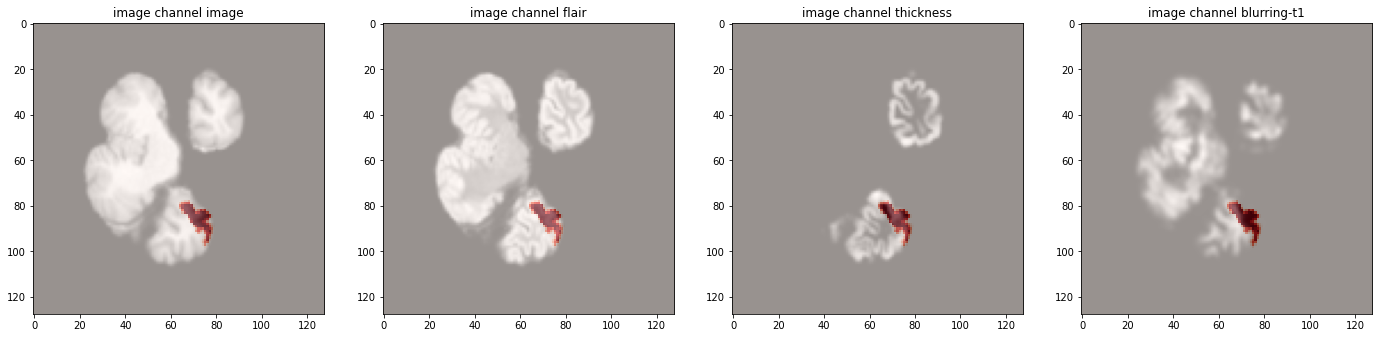

segmentaion shape: torch.Size([1, 128, 128, 128])


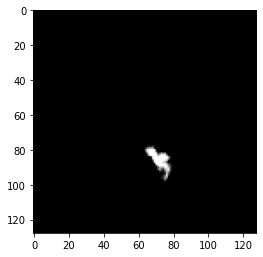

In [19]:
print(f"image shape: {train_data_example['image'].shape}")
num_of_channels = len(feat_params)
label_ind = round(np.where(train_data_example["seg"]>0)[3].shape[0] / 2)
label_pos = np.where(train_data_example["seg"]>0)[3][label_ind]
plt.figure("image", (24, 6))
for i in range(num_of_channels):
    plt.subplot(1, num_of_channels, i + 1)
    plt.title(f"image channel {feat_params[i]}")
    plt.imshow(train_data_example['image'][i, :, :, label_pos], cmap="gray")
    plt.imshow(train_data_example["seg"][0,:, :, label_pos],interpolation='none', cmap='Reds', alpha=0.6)
    #plt.colorbar()
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"segmentaion shape: {train_data_example['seg'].shape}")
plt.figure("seg", (4, 6))
plt.imshow(train_data_example["seg"][0,:, :, label_pos], cmap="gray")
#plt.colorbar()
plt.show()

In [20]:
train_ds = monai.data.Dataset(data=train_files, transform=train_transf)
train_loader = DataLoader(
    train_ds,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    collate_fn=list_data_collate,
    pin_memory=torch.cuda.is_available(),
)

val_ds = monai.data.Dataset(data=val_files, transform=val_transf)
val_loader = DataLoader(val_ds, batch_size=2, num_workers=0, collate_fn=list_data_collate)

In [21]:
ind = 20
train_files[ind]

{'image': ['/workspace/RawData/Features/prep_wf/sub-56/sub-56_t1_brain-final.nii.gz',
  '/workspace/RawData/Features/prep_wf/sub-56/sub-56_fl_brain-final.nii.gz',
  '/workspace/RawData/Features/prep_wf/sub-56/thickness_mni.nii',
  '/workspace/RawData/Features/prep_wf/sub-56/Blurring_T1.nii.gz'],
 'seg': '/workspace/RawData/Features/preprocessed_data/label_bernaskoni/56.nii.gz'}

## Transform random rotate augmentation example

### Before augmentation

/root/miniconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


[34. 35. 36. 37. 38. 39. 40.]


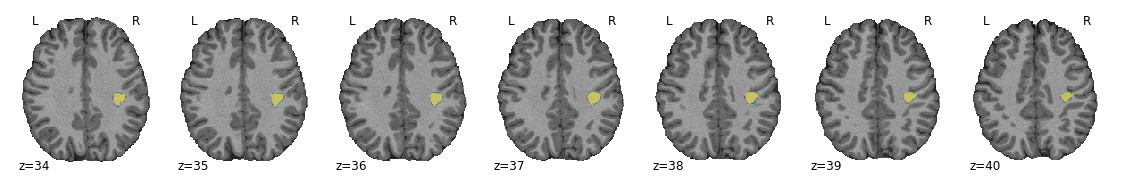

In [22]:
from nilearn.plotting import plot_img
plot_img = plot_img(train_files[ind]['seg'],
         bg_img=train_files[ind]['image'][0],
         threshold=0.1, alpha=0.5, display_mode='z')
plot_img
print(plot_img.cut_coords) # get coordinate of z where lesion center mass

### Augmentation

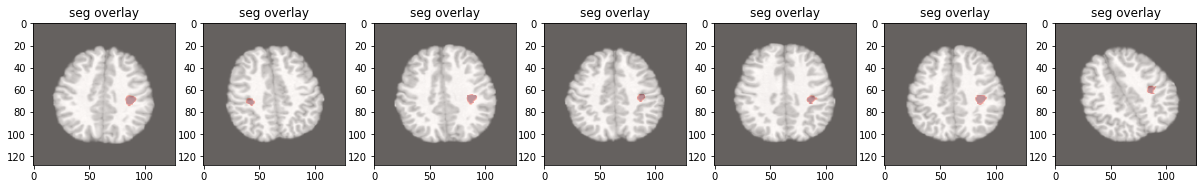

In [23]:
plt.figure(figsize=(30,30))
for i in range(7):
    plt.subplot(1, 10, i+1)
    item = train_loader.dataset[ind]
    image, segme = item["image"], item["seg"]
    lab_loc = round(np.where(segme>0)[3].shape[0] / 2)
    lab_pos = np.where(segme>0)[3][lab_loc]
    plt.imshow(np.rot90(image[0,:, :, lab_pos]), cmap='gray')
    plt.imshow(np.rot90(segme[0,:, :, lab_pos]), cmap="Reds", alpha=0.4)
    plt.title("seg overlay")
plt.show()

In [24]:
a = train_loader.dataset.data[0]['seg'].split('/')[6].split('.')[0]
a

'76'

In [25]:
train_loader.dataset.data[0]['image'][2]

'/workspace/RawData/Features/prep_wf/sub-76/thickness_mni.nii'

In [26]:
def one_epoch(model, 
                criterion, 
                opt, 
                config, 
                dataloader, 
                device, 
                writer, 
                epoch, 
                metric_dict_epoch, 
                n_iters_total=0,
                augmentation=None, 
                is_train=True):


    # use amp to accelerate training
    if config.opt.use_scaler:
        scaler = torch.cuda.amp.GradScaler()

    phase_name = 'train' if is_train else 'val'
    loss_name = config.opt.criterion
    metric_dict = defaultdict(list)
    target_metric_name = config.model.target_metric_name 

    if not is_train:
        model.eval()
    else:
        model.train()

    # used to turn on/off gradients
    grad_context = torch.autograd.enable_grad if is_train else torch.no_grad
    with grad_context():
        iterator = enumerate(dataloader)
        val_predictions = {}
        for iter_i, data_tensors in iterator:
            
            brain_tensor, label_tensor = data_tensors['image'], data_tensors['seg']
            #mask_tensor = brain_tensor
            t1 = time.time()


            brain_tensor = brain_tensor.to(device)
            label_tensor = label_tensor.to(device)
            #mask_tensor = mask_tensor.to(device)

            # forward pass
            with autocast(enabled=config.opt.use_scaler):
                label_tensor_predicted = model(brain_tensor) # -> [bs,1,ps,ps,ps]

                loss = criterion(label_tensor_predicted, label_tensor) 


            if is_train:
                opt.zero_grad()

                if config.opt.use_scaler:
                    scaler.scale(loss).backward()
                else:
                    loss.backward()
                
                if hasattr(config.opt, "grad_clip"):
                    if config.opt.use_scaler:
                        scaler.unscale_(opt)
                        torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                           config.opt.grad_clip)

                metric_dict['grad_norm'].append(calc_gradient_norm(filter(lambda x: x[1].requires_grad, 
                                                model.named_parameters())))

                if config.opt.use_scaler:
                    scaler.step(opt)
                    scaler.update()
                else:
                    opt.step()


            t2 = time.time()    
            dt = t2-t1 # inference time
            
            metric_dict[f'batch_time'].append(dt)
            metric_dict[f'{loss_name}'].append(loss.item())
            #label_tensor_predicted = label_tensor_predicted*mask_tensor
            dice_score = DiceScoreBinary(label_tensor_predicted, label_tensor)
            coverage = (label_tensor_predicted*label_tensor).sum() / label_tensor.sum()
            
            if not is_train:
#                #label = dataloader.dataset.labels[iter_i]
                 #label = dataloader.dataset[iter_i]['seg']
                label = dataloader.dataset.data[iter_i]['seg'].split('/')[6].split('.')[0]
                val_predictions[label] = label_tensor_predicted.detach().cpu().numpy()
            
            metric_dict['coverage'].append(coverage.item())
            metric_dict['dice_score'].append(dice_score.item())
            
            #########
            # PRINT #
            #########
            message = f'For {phase_name}, iter: {iter_i},'
            for title, value in metric_dict.items():
                if title == 'grad_norm':
                    v = np.round(value[-1],6)
                else:
                    v = np.round(value[-1],3)
                message+=f' {title}:{v}'
            print(message)

            # print(f'Epoch: {epoch}, Iter: {iter_i}, \n \
            # Loss_{loss_name}: {loss.item()}, Dice-score: {dice_score.item()}, \n \
            # time: {np.round(dt,2)}-s')

            if is_train and writer is not None:
                for title, value in metric_dict.items():
                    writer.add_scalar(f"{phase_name}_{title}", value[-1], n_iters_total)

            n_iters_total += 1

    target_metric = 0
    for title, value in metric_dict.items():
        m = np.mean(value)
        metric_dict_epoch[phase_name + '_' + title].append(m)
        if title == target_metric_name:
            target_metric = m
        if writer is not None:
            writer.add_scalar(f"{phase_name}_{title}_epoch", m, epoch)
            
    #####################
    # SAVING BEST PREDS #
    #####################
    target_metrics_epoch = metric_dict_epoch[f'val_{target_metric_name}']
    if not is_train:
        if config.dataset.save_best_val_predictions:
            # use greedy-saving: save only if the target metric is improved
            if len(target_metrics_epoch) == 1 or target_metrics_epoch[-1] >= target_metrics_epoch[-2]:
                for label, pred in val_predictions.items():
                        #torch.save(pred, os.path.join(config.dataset.val_preds_path, f'{label}'))
                        torch.save(pred, os.path.join(config.dataset.val_preds_path, f'{label}'))


    return n_iters_total, target_metric

In [28]:
# Plot Image with one epoch iterator

def one_epoch(model, 
                criterion, 
                opt, 
                config, 
                dataloader, 
                device, 
                writer, 
                epoch, 
                metric_dict_epoch, 
                n_iters_total=0,
                augmentation=None, 
                is_train=True):

    plt.figure(figsize=(30,30))
    # use amp to accelerate training
    if config.opt.use_scaler:
        scaler = torch.cuda.amp.GradScaler()

    phase_name = 'train' if is_train else 'val'
    loss_name = config.opt.criterion
    metric_dict = defaultdict(list)
    target_metric_name = config.model.target_metric_name 

    if not is_train:
        model.eval()
    else:
        model.train()

    # used to turn on/off gradients
    grad_context = torch.autograd.enable_grad if is_train else torch.no_grad
    with grad_context():
        iterator = enumerate(dataloader)
        val_predictions = {}
        for iter_i, data_tensors in iterator:
            image, segme = data_tensors['image'], data_tensors['seg']
            
            plt.subplot(1, 11, iter_i+1)
            lab_loc = round(np.where(segme>0)[4].shape[0] / 2)
            lab_pos = np.where(segme>0)[4][lab_loc]
            plt.imshow(image[0, 0,:, :, lab_pos], cmap='gray')
            plt.imshow(segme[0, 0,:, :, lab_pos], cmap="Reds", alpha=0.4)
            plt.imshow(image[0, 2,:, :, lab_pos], cmap="Greens", alpha=0.2)
            #torch.Size([2, 3, 128, 128, 128]) torch.Size([2, 1, 128, 128, 128])
            if iter_i > 10:
                break


In [27]:
print(config.opt.criterion)

Dice


In [28]:
from datetime import datetime
from tensorboardX import SummaryWriter
from losses import DiceScoreBinary,\
                   DiceLossBinary,\
                   symmetric_focal_loss,\
                sym_unified_focal_loss,\
                symmetric_focal_tversky_loss,\
                DiceSFL,\
                tversky_loss
import torch.optim as optim
from models.v2v import V2VModel
from utils import save, parse_args, get_capacity, calc_gradient_norm
from collections import defaultdict
from IPython.core.debugger import set_trace
import traceback
import torch.nn.functional as F
from torch.cuda.amp import autocast



##########
# LOGDIR #
##########
MAKE_LOGS = config.default.make_logs
SAVE_MODEL = config.opt.save_model if hasattr(config.opt, "save_model") else True
DEVICE = config.opt.device if hasattr(config.opt, "device") else 1
device = torch.device(DEVICE)
print(device)


experiment_name = '{}@{}'.format(config.default.experiment_comment, datetime.now().strftime("%d.%m.%Y-%H"))
print("Experiment name: {}".format(experiment_name))

writer = None
if MAKE_LOGS:
    experiment_dir = os.path.join(config.default.log_dir, experiment_name)
    if os.path.isdir(experiment_dir):
        shutil.rmtree(experiment_dir)
    os.makedirs(experiment_dir)
    shutil.copy('configs/config.ini', os.path.join(experiment_dir, "config.ini"))
    
    # write .json dataset log
    ds_split_log = {"train": train_subs_indcs,
                    "val": val_subs_indcs}

    with open(os.path.join(config.default.log_dir, experiment_name, 'train_test_split.json'), 'w') as f:
        trvasp = json.dumps(ds_split_log)
        f.write(trvasp)
        f.close()

    if config.dataset.save_best_val_predictions:
        val_preds_path = os.path.join(experiment_dir, 'best_val_preds')
        config.dataset.val_preds_path = val_preds_path
        os.makedirs(val_preds_path)
    writer = SummaryWriter(os.path.join(experiment_dir, "tb"))
    
#########
# MODEL #
#########
if config.model.name == "v2v":
    model = V2VModel(config).to(device)
elif config.model.name == "unet3d":
    model = UnetModel(config).to(device)
capacity = get_capacity(model)

print(f'Model created! Capacity: {capacity}')

if hasattr(config.model, 'weights'):
    model_dict = torch.load(os.path.join(config.model.weights, 'checkpoints/weights.pth'))
    print(f'LOADING from {config.model.weights} \n epoch:', model_dict['epoch'])
    model.load_state_dict(model_dict['model_state'])


################
# CREATE OPTIM #
################
criterion = {
    "BCE":torch.nn.BCELoss, # [probabilities, target]
    "Dice":DiceLossBinary,
    "DiceBCE":None,
    "DiceSFL": DiceSFL(delta=config.opt.delta, gamma=config.opt.gamma),
    "TL": tversky_loss(delta=config.opt.delta),
    "FTL": symmetric_focal_tversky_loss(delta=config.opt.delta, gamma=config.opt.gamma),
    "SFL": symmetric_focal_loss(delta=config.opt.delta, gamma=config.opt.gamma),
    "USFL":sym_unified_focal_loss(weight=config.opt.weight, # 0.5
                                     delta=config.opt.delta,  # 0.6
                                     gamma=config.opt.gamma) # 0.5
}[config.opt.criterion]
opt = optim.Adam(model.parameters(), lr=config.opt.lr)

#####################
# ASSIGN DATALOADER #
#####################
train_dataloader = train_loader
val_dataloader = val_loader

#item = train_loader.dataset[ind]
#image, segme = item["image"], item["seg"]

cuda:2
Experiment name: v2v-AUG_YARKIN_onesite-subs_autocast_DICE-loss_lr-1e-3_t1+flair+thick+blurt1@22.06.2022-19
Model created! Capacity: 11.73


In [133]:
model

V2VModel(
  (front_layers): Sequential(
    (0): Basic3DBlock(
      (block): Sequential(
        (0): Conv3d(3, 16, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=(3, 3, 3))
        (1): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
    (1): Res3DBlock(
      (res_branch): Sequential(
        (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01)
        (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (4): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      )
      (skip_con): Sequential(
        (0): Conv3d(16, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
        (1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Fals

In [ ]:
print('Start training!')
metric_dict_epoch = defaultdict(list)
n_iters_total_train = 0 
n_iters_total_val = 0
target_metric = 0
target_metric_prev = -1
try:
    for epoch in range(config.opt.start_epoch, config.opt.n_epochs):
        print (f'TRAIN EPOCH: {epoch} ... ')
        n_iters_total_train, _  = one_epoch(model, 
                                        criterion, 
                                        opt, 
                                        config, 
                                        train_dataloader, 
                                        device, 
                                        writer, 
                                        epoch, 
                                        metric_dict_epoch, 
                                        n_iters_total_train,
                                        augmentation=None, # augmentation None because compose in dataloader
                                        is_train=True)

        print (f'VAL EPOCH: {epoch} ... ')
        n_iters_total_val, target_metric = one_epoch(model, 
                                        criterion, 
                                        opt, 
                                        config, 
                                        val_dataloader, 
                                        device, 
                                        writer, 
                                        epoch, 
                                        metric_dict_epoch, 
                                        n_iters_total_val,
                                        augmentation=None,
                                        is_train=False)

        if SAVE_MODEL and MAKE_LOGS:
            if not config.model.use_greedy_saving:
                print(f'SAVING...')
                save(experiment_dir, model, opt, epoch)
            # use greedy-saving: save only if the target metric is improved
            elif target_metric > target_metric_prev:
                print(f'target_metric = {target_metric}, SAVING...')
                save(experiment_dir, model, opt, epoch)
                target_metric_prev = target_metric
except Exception as e:
    print(traceback.format_exc())
    #set_trace()
    # keyboard interrupt
    if MAKE_LOGS:
        np.save(os.path.join(experiment_dir, 'metric_dict_epoch'), metric_dict_epoch)     


Start training!
TRAIN EPOCH: 0 ... 
For train, iter: 0, grad_norm:4125.592311 batch_time:3.072 Dice:0.999 coverage:0.169 dice_score:0.001
For train, iter: 12, grad_norm:2244.503859 batch_time:2.999 Dice:0.992 coverage:0.73 dice_score:0.008
For train, iter: 13, grad_norm:1091.755573 batch_time:3.002 Dice:0.995 coverage:0.445 dice_score:0.005
For train, iter: 14, grad_norm:7862.322366 batch_time:2.998 Dice:0.983 coverage:0.69 dice_score:0.017
For train, iter: 15, grad_norm:529.125124 batch_time:3.009 Dice:0.997 coverage:0.887 dice_score:0.003
For train, iter: 16, grad_norm:1358.783927 batch_time:3.048 Dice:0.993 coverage:0.635 dice_score:0.007
For train, iter: 17, grad_norm:1393.479571 batch_time:2.997 Dice:0.993 coverage:0.796 dice_score:0.007
For train, iter: 18, grad_norm:873.708559 batch_time:2.994 Dice:0.994 coverage:0.704 dice_score:0.006
For train, iter: 19, grad_norm:606.299534 batch_time:2.992 Dice:0.999 coverage:0.295 dice_score:0.001
For train, iter: 20, grad_norm:2370.744533 

NaN or Inf found in input tensor.


For train, iter: 11, grad_norm:inf batch_time:3.007 Dice:0.659 coverage:0.299 dice_score:0.341
For train, iter: 12, grad_norm:95149.492239 batch_time:3.018 Dice:0.79 coverage:0.223 dice_score:0.21
For train, iter: 13, grad_norm:5463.514379 batch_time:3.052 Dice:0.965 coverage:0.037 dice_score:0.035
For train, iter: 14, grad_norm:20931.83504 batch_time:3.021 Dice:0.897 coverage:0.188 dice_score:0.103
For train, iter: 15, grad_norm:21991.489636 batch_time:3.014 Dice:0.912 coverage:0.602 dice_score:0.088
For train, iter: 16, grad_norm:16695.579588 batch_time:3.008 Dice:0.91 coverage:0.26 dice_score:0.09
For train, iter: 17, grad_norm:7381.711566 batch_time:3.028 Dice:0.972 coverage:0.078 dice_score:0.028
For train, iter: 18, grad_norm:41158.253293 batch_time:3.052 Dice:0.802 coverage:0.456 dice_score:0.198
For train, iter: 19, grad_norm:2228.349354 batch_time:3.019 Dice:0.989 coverage:0.033 dice_score:0.011
For train, iter: 20, grad_norm:9478.972664 batch_time:3.03 Dice:0.947 coverage:0.0

NaN or Inf found in input tensor.


For train, iter: 26, grad_norm:2402.604942 batch_time:2.139 Dice:0.995 coverage:0.015 dice_score:0.005
VAL EPOCH: 7 ... 
For val, iter: 0, batch_time:0.025 Dice:0.866 coverage:0.277 dice_score:0.134
For val, iter: 1, batch_time:0.03 Dice:0.857 coverage:0.451 dice_score:0.143
For val, iter: 2, batch_time:0.029 Dice:0.871 coverage:0.386 dice_score:0.129
For val, iter: 3, batch_time:0.028 Dice:0.975 coverage:0.093 dice_score:0.025
For val, iter: 4, batch_time:0.025 Dice:0.855 coverage:0.183 dice_score:0.145
For val, iter: 5, batch_time:0.025 Dice:0.919 coverage:0.245 dice_score:0.081
For val, iter: 6, batch_time:0.02 Dice:0.94 coverage:0.091 dice_score:0.06
TRAIN EPOCH: 8 ... 
For train, iter: 0, grad_norm:63947.219403 batch_time:3.053 Dice:0.88 coverage:0.268 dice_score:0.12
For train, iter: 1, grad_norm:41398.133462 batch_time:3.034 Dice:0.909 coverage:0.295 dice_score:0.091
For train, iter: 2, grad_norm:11691.571081 batch_time:3.018 Dice:0.979 coverage:0.143 dice_score:0.021
For train,

NaN or Inf found in input tensor.


For train, iter: 11, grad_norm:inf batch_time:3.03 Dice:0.667 coverage:0.207 dice_score:0.333
For train, iter: 12, grad_norm:46200.093185 batch_time:3.014 Dice:0.873 coverage:0.119 dice_score:0.127
For train, iter: 13, grad_norm:7394.859173 batch_time:3.018 Dice:0.972 coverage:0.019 dice_score:0.028
For train, iter: 14, grad_norm:21179.072333 batch_time:3.026 Dice:0.879 coverage:0.086 dice_score:0.121
For train, iter: 15, grad_norm:19796.134289 batch_time:3.026 Dice:0.816 coverage:0.309 dice_score:0.184
For train, iter: 16, grad_norm:11939.399289 batch_time:3.022 Dice:0.872 coverage:0.162 dice_score:0.128
For train, iter: 17, grad_norm:20238.173363 batch_time:3.059 Dice:0.94 coverage:0.072 dice_score:0.06
For train, iter: 18, grad_norm:34668.433004 batch_time:3.019 Dice:0.771 coverage:0.355 dice_score:0.229
For train, iter: 19, grad_norm:1998.545904 batch_time:3.013 Dice:0.996 coverage:0.015 dice_score:0.004
For train, iter: 20, grad_norm:13303.686375 batch_time:3.017 Dice:0.857 covera

NaN or Inf found in input tensor.


For train, iter: 26, grad_norm:3132.704323 batch_time:2.133 Dice:0.995 coverage:0.01 dice_score:0.005
VAL EPOCH: 9 ... 
For val, iter: 0, batch_time:0.025 Dice:0.596 coverage:0.332 dice_score:0.404
For val, iter: 1, batch_time:0.025 Dice:0.446 coverage:0.678 dice_score:0.554
For val, iter: 2, batch_time:0.028 Dice:0.45 coverage:0.618 dice_score:0.55
For val, iter: 3, batch_time:0.028 Dice:0.989 coverage:0.012 dice_score:0.011
For val, iter: 4, batch_time:0.025 Dice:0.762 coverage:0.161 dice_score:0.238
For val, iter: 5, batch_time:0.029 Dice:0.774 coverage:0.216 dice_score:0.226
For val, iter: 6, batch_time:0.025 Dice:0.979 coverage:0.014 dice_score:0.021
TRAIN EPOCH: 10 ... 
For train, iter: 0, grad_norm:32102.281802 batch_time:3.053 Dice:0.701 coverage:0.341 dice_score:0.299
For train, iter: 1, grad_norm:45539.230633 batch_time:3.035 Dice:0.723 coverage:0.293 dice_score:0.277
For train, iter: 2, grad_norm:24140.058983 batch_time:3.013 Dice:0.915 coverage:0.213 dice_score:0.085
For tr

NaN or Inf found in input tensor.


For train, iter: 4, grad_norm:inf batch_time:3.008 Dice:0.569 coverage:0.24 dice_score:0.431
For train, iter: 5, grad_norm:51146.102688 batch_time:3.06 Dice:0.806 coverage:0.127 dice_score:0.194
For train, iter: 6, grad_norm:41944.060254 batch_time:3.028 Dice:0.805 coverage:0.121 dice_score:0.195
For train, iter: 7, grad_norm:44946.054099 batch_time:3.026 Dice:0.745 coverage:0.21 dice_score:0.255
For train, iter: 8, grad_norm:39828.457784 batch_time:3.013 Dice:0.869 coverage:0.349 dice_score:0.131
For train, iter: 9, grad_norm:13626.696252 batch_time:3.025 Dice:0.825 coverage:0.355 dice_score:0.175
For train, iter: 10, grad_norm:1463.901021 batch_time:3.017 Dice:0.996 coverage:0.011 dice_score:0.004
For train, iter: 11, grad_norm:33686.855511 batch_time:3.055 Dice:0.438 coverage:0.581 dice_score:0.562
For train, iter: 12, grad_norm:13687.377012 batch_time:3.019 Dice:0.729 coverage:0.411 dice_score:0.271
For train, iter: 13, grad_norm:20936.165951 batch_time:3.019 Dice:0.945 coverage:0.

NaN or Inf found in input tensor.


For train, iter: 26, grad_norm:2537.957388 batch_time:2.134 Dice:0.996 coverage:0.011 dice_score:0.004
VAL EPOCH: 10 ... 
For val, iter: 0, batch_time:0.028 Dice:0.568 coverage:0.422 dice_score:0.432
For val, iter: 1, batch_time:0.025 Dice:0.479 coverage:0.657 dice_score:0.521
For val, iter: 2, batch_time:0.028 Dice:0.525 coverage:0.552 dice_score:0.475
For val, iter: 3, batch_time:0.025 Dice:0.99 coverage:0.013 dice_score:0.01
For val, iter: 4, batch_time:0.028 Dice:0.724 coverage:0.202 dice_score:0.276
For val, iter: 5, batch_time:0.025 Dice:0.766 coverage:0.281 dice_score:0.234
For val, iter: 6, batch_time:0.02 Dice:0.983 coverage:0.013 dice_score:0.017
TRAIN EPOCH: 11 ... 
For train, iter: 0, grad_norm:50872.18693 batch_time:3.044 Dice:0.658 coverage:0.366 dice_score:0.342
For train, iter: 1, grad_norm:70391.20301 batch_time:3.018 Dice:0.766 coverage:0.233 dice_score:0.234
For train, iter: 2, grad_norm:24450.537121 batch_time:3.008 Dice:0.915 coverage:0.179 dice_score:0.085
For tra

NaN or Inf found in input tensor.


For train, iter: 4, grad_norm:inf batch_time:3.012 Dice:0.712 coverage:0.144 dice_score:0.288
For train, iter: 5, grad_norm:62877.622016 batch_time:3.074 Dice:0.831 coverage:0.088 dice_score:0.169
For train, iter: 6, grad_norm:42666.472485 batch_time:3.026 Dice:0.866 coverage:0.065 dice_score:0.134
For train, iter: 7, grad_norm:64315.033897 batch_time:3.016 Dice:0.673 coverage:0.227 dice_score:0.327
For train, iter: 8, grad_norm:20983.374104 batch_time:3.011 Dice:0.923 coverage:0.237 dice_score:0.077
For train, iter: 9, grad_norm:12835.354471 batch_time:3.004 Dice:0.859 coverage:0.302 dice_score:0.141
For train, iter: 10, grad_norm:1045.759883 batch_time:3.04 Dice:0.997 coverage:0.011 dice_score:0.003
For train, iter: 11, grad_norm:44552.435735 batch_time:3.012 Dice:0.469 coverage:0.666 dice_score:0.531
For train, iter: 12, grad_norm:25009.670609 batch_time:3.007 Dice:0.756 coverage:0.521 dice_score:0.244
For train, iter: 13, grad_norm:4079.861091 batch_time:3.011 Dice:0.984 coverage:0

NaN or Inf found in input tensor.


For train, iter: 26, grad_norm:3972.035686 batch_time:2.136 Dice:0.993 coverage:0.01 dice_score:0.007
VAL EPOCH: 11 ... 
For val, iter: 0, batch_time:0.029 Dice:0.625 coverage:0.295 dice_score:0.375
For val, iter: 1, batch_time:0.028 Dice:0.423 coverage:0.642 dice_score:0.577
For val, iter: 2, batch_time:0.025 Dice:0.338 coverage:0.685 dice_score:0.662
For val, iter: 3, batch_time:0.029 Dice:0.989 coverage:0.011 dice_score:0.011
For val, iter: 4, batch_time:0.028 Dice:0.742 coverage:0.166 dice_score:0.258
For val, iter: 5, batch_time:0.025 Dice:0.71 coverage:0.207 dice_score:0.29
For val, iter: 6, batch_time:0.02 Dice:0.958 coverage:0.025 dice_score:0.042
TRAIN EPOCH: 12 ... 
For train, iter: 0, grad_norm:49961.093014 batch_time:3.025 Dice:0.659 coverage:0.299 dice_score:0.341
For train, iter: 1, grad_norm:44737.975823 batch_time:3.07 Dice:0.632 coverage:0.445 dice_score:0.368
For train, iter: 2, grad_norm:9042.385094 batch_time:3.026 Dice:0.973 coverage:0.059 dice_score:0.027
For trai

In [7]:
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd


def parse_tensorboard(path, scalars):
    """returns a dictionary of pandas dataframes for each requested scalar"""
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={event_accumulator.SCALARS: 0},
    )
    _absorb_print = ea.Reload()
    # make sure the scalars are in the event accumulator tags
    assert all(
        s in ea.Tags()["scalars"] for s in scalars
    ), "some scalars were not found in the event accumulator"
    return {k: pd.DataFrame(ea.Scalars(k)) for k in scalars}

In [ ]:
parse_tensorboard('/workspace/RawData/FCDNet/logs/v2v-NOAUG-autocast_DICE-loss_mask@17.06.2022-22/tb/events.out.tfevents.1655506733.90346d20369c', 'event')

In [41]:
from monai.losses import DiceLoss

device = torch.device("cuda:2")
max_epochs = 300
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
model = monai.networks.nets.SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=4,
    out_channels=1,
    dropout_prob=0.1,
).to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose(
    [EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)]
)


# define inference method
def inference(input):

    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

In [43]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["seg"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():

            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["seg"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/300
1/73, train_loss: 0.9996, step time: 7.6338
2/73, train_loss: 0.9951, step time: 1.1643
3/73, train_loss: 0.9969, step time: 1.1656
4/73, train_loss: 0.9974, step time: 1.1578
5/73, train_loss: 0.9972, step time: 1.1599
6/73, train_loss: 0.9975, step time: 1.1531
7/73, train_loss: 0.9990, step time: 1.1503
8/73, train_loss: 0.9986, step time: 1.1463
9/73, train_loss: 0.9980, step time: 1.1550
10/73, train_loss: 0.9991, step time: 1.1491
11/73, train_loss: 0.9998, step time: 1.1350
12/73, train_loss: 0.9958, step time: 1.1638
13/73, train_loss: 0.9994, step time: 1.1471
14/73, train_loss: 0.9992, step time: 1.1457
15/73, train_loss: 0.9973, step time: 1.1537
16/73, train_loss: 0.9945, step time: 1.1624
17/73, train_loss: 0.9932, step time: 1.1666
18/73, train_loss: 0.9990, step time: 1.1506
19/73, train_loss: 0.9982, step time: 1.1539
20/73, train_loss: 0.9978, step time: 1.1560
21/73, train_loss: 0.9988, step time: 1.1419
22/73, train_loss: 0.9983, step time: 1.1

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [33]:
#trainer = create_multigpu_supervised_trainer(model, optimizer, loss_function, None)
#trainer.run(train_ds['image'], max_epochs=max_epochs, epoch_length=2)

In [34]:
val_data = monai.utils.misc.first(val_loader)
print(val_data["image"].shape, val_data["seg"].shape)

torch.Size([2, 4, 128, 128, 128]) torch.Size([2, 1, 128, 128, 128])


In [37]:
val_data["image"][0].type()

'torch.FloatTensor'

In [38]:
val_data["seg"][0].type()

'torch.IntTensor'

In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.show()

In [ ]:
model.load_state_dict(
    torch.load(os.path.join(root_dir, "best_metric_model.pth"))
)
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[0]["image"].unsqueeze(0).to(device)
    roi_size = (192, 192, 192)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    num_of_channels = len(feat_params)
    for i in range(num_of_channels):
        plt.subplot(1, num_of_channels, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[0]["image"][i, :, :, int(np.where(val_ds[0]["seg"] == 1)[2][5])].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image

    plt.title(f"label channel {i}")
    plt.imshow(val_ds[0]["seg"][0, :, :, int(np.where(val_ds[0]["seg"] == 1)[2][5])].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.title(f"output channel {i}")
    plt.imshow(val_output[0, :, :, int(np.where(val_ds[0]["seg"] == 1)[2][5])].detach().cpu())
    plt.show()

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr)
trainer = create_multigpu_supervised_trainer(net, opt, fake_loss, None)
trainer.run(fake_data_stream(), max_epochs=max_epochs, epoch_length=2)

In [ ]:
print("image shape:", img_dataset[0][0].shape)
print("label. shape:", img_dataset[0][1].shape)

In [ ]:
dataloader = DataLoader(img_dataset, batch_size=1, shuffle=True, num_workers=0)
for epoch in range(2):
    for i, batch in enumerate(dataloader):
        print(epoch, i, batch.data.numpy().flatten().tolist())